In [27]:
import numpy as np
import pandas as pd
from sklearn import linear_model
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse
from sqlalchemy import create_engine

import warnings
warnings.filterwarnings('ignore')

# I want to read the full contents of each sentiment
pd.set_option('display.max_colwidth', -1)
pd.options.display.max_columns = None

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

# Functions

In [28]:
def quick_histogram(series,**kwargs):
    title = kwargs.get('title','Plot of series')
    xlabel = kwargs.get('xlabel','X-axis label')
    ylabel = kwargs.get('ylabel','count')
    plt.hist(series)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

## This dataset consists of 79 variables describing many aspects of residential homes in Ames, Iowa. Using this data, your task will be to predict the prices of the houses. You can find the descriptions of the variables here: [House Prices](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)

In [29]:
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
house_df = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()


house_df.head(10)

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremodadd,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating,heatingqc,centralair,electrical,firstflrsf,secondflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,fireplacequ,garagetype,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,None,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,None,None,None,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1.5Fin,5,5,1993,1995,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,Wood,Gd,TA,No,GLQ,732,Unf,0,64,796,GasA,Ex,Y,SBrkr,796,566,0,1362,1,0,1,1,1,1,TA,5,Typ,0,None,Attchd,1993.0,Unf,2,480,TA,TA,Y,40,30,0,320,0,0,None,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,2004,2005,Gable,CompShg,VinylSd,VinylSd,Stone,186.0,Gd,TA,PConc,Ex,TA,Av,GLQ,1369,Unf,0,317,1686,GasA,Ex,Y,SBrkr,1694,0,0,1694,1,0,2,0,3,1,Gd,7,Typ,1,Gd,Attchd,2004.0,RFn,2,636,TA,TA,Y,255,57,0,0,0,0,None,None,None,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosN,Norm,1Fam,2Story,7,6,1973,1973,Gable,CompShg,HdBoard,HdBoard,Stone,240.0,TA,TA,CBlock,Gd,TA,Mn,ALQ,859,BLQ,32,216,1107,GasA,Ex,Y,SBrkr,1107,983,0,2090,1,0,2,1,3,1,TA,7,Typ,2,TA,Attchd,1973.0,RFn,2,484,TA,TA,Y,235,204,228,0,0,0,None,None,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,1Fam,1.5Fin,7,5,1931,1950,Gable,CompShg,BrkFace,Wd Shng,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0,Unf,0,952,952,GasA,Gd,Y,FuseF,1022,752,0,1774,0,0,2,0,2,2,TA,8,Min1,2,TA,Detchd,1931.0,Unf,2,468,Fa,TA,Y,90,0,205,0,0,0,None,None,None,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,None,Reg,Lvl,AllPub,Corner,Gtl,BrkSide,Artery,Artery,2fmCon,1.5Unf,5,6,1939,1950,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA

### Data cleaning, feature building

In [30]:
# Filling in missing values with 0s, or "NA"
house_df['lotfrontage'].fillna(0,inplace=True)
house_df['masvnrtype'].fillna("NA",inplace=True)
house_df['masvnrarea'].fillna(0.0,inplace=True)
house_df['bsmtqual'].fillna("NA",inplace=True) 
house_df['bsmtcond'].fillna("NA",inplace=True) 
house_df['bsmtfintype1'].fillna("NA",inplace=True) 
house_df['bsmtexposure'].fillna("NA",inplace=True) 
house_df['bsmtfintype2'].fillna("NA",inplace=True) 
house_df['fireplacequ'].fillna("NA",inplace=True)
house_df['garagetype'].fillna("NA",inplace=True) 
house_df['garageyrblt'].fillna("NA",inplace=True) 
house_df['garagefinish'].fillna("NA",inplace=True) 
house_df['garagequal'].fillna("NA",inplace=True) 
house_df['garagecond'].fillna("NA",inplace=True)

In [31]:
# Dropping poorly populated or irrelevant variables
house_df.drop(columns=['id','alley','electrical','poolqc','fence','miscfeature'],inplace=True)

Performing a log transformation on lot area helps make this distribution look more normal. Let's run with that.

In [32]:
house_df['log_lotarea'] = np.log(house_df['lotarea'])

In [33]:
house_df['has_porch'] = ((house_df['openporchsf'] > 0) | (house_df['enclosedporch'] > 0) | (house_df['threessnporch'] > 0) | (house_df['screenporch'] > 0)).map({True: 1, False: 0})
house_df['has_deck'] = (house_df['wooddecksf'] > 0).map({True: 1, False: 0})

In [34]:
# Start with these features of interest. 
vars_of_interest = ['saleprice','log_lotarea','neighborhood','bldgtype','housestyle','yearbuilt','fireplaces',
                    'heating','centralair','grlivarea','garagearea','has_deck','has_porch']

house_interest_df = house_df[vars_of_interest]
house_interest_df.head()

,saleprice,log_lotarea,neighborhood,bldgtype,housestyle,yearbuilt,fireplaces,heating,centralair,grlivarea,garagearea,has_deck,has_porch
0,208500,9.041922,CollgCr,1Fam,2Story,2003,0,GasA,Y,1710,548,0,1
1,181500,9.169518,Veenker,1Fam,1Story,1976,1,GasA,Y,1262,460,1,0
2,223500,9.328123,CollgCr,1Fam,2Story,2001,1,GasA,Y,1786,608,0,1
3,140000,9.164296,Crawfor,1Fam,2Story,1915,1,GasA,Y,1717,642,0,1
4,250000,9.565214,NoRidge,1Fam,2Story,2000,1,GasA,Y,2198,836,1,1


In [35]:
# Append one-hot versions of neighborhoods and house style to the dataframe of interesting variables
house_interest_df = pd.concat([house_interest_df, pd.get_dummies(house_df['neighborhood'],drop_first=True)], axis=1)
house_interest_df = pd.concat([house_interest_df, pd.get_dummies(house_df['housestyle'],drop_first=True)], axis=1)
house_interest_df.head()

,saleprice,log_lotarea,neighborhood,bldgtype,housestyle,yearbuilt,fireplaces,heating,centralair,grlivarea,garagearea,has_deck,has_porch,Blueste,BrDale,BrkSide,ClearCr,CollgCr,Crawfor,Edwards,Gilbert,IDOTRR,MeadowV,Mitchel,NAmes,NPkVill,NWAmes,NoRidge,NridgHt,OldTown,SWISU,Sawyer,SawyerW,Somerst,StoneBr,Timber,Veenker,1.5Unf,1Story,2.5Fin,2.5Unf,2Story,SFoyer,SLvl
0,208500,9.041922,CollgCr,1Fam,2Story,2003,0,GasA,Y,1710,548,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,181500,9.169518,Veenker,1Fam,1Story,1976,1,GasA,Y,1262,460,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
2,223500,9.328123,CollgCr,1Fam,2Story,2001,1,GasA,Y,1786,608,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,140000,9.164296,Crawfor,1Fam,2Story,1915,1,GasA,Y,1717,642,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,250000,9.565214,NoRidge,1Fam,2Story,2000,1,GasA,Y,2198,836,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


### Split your data into train and test sets.

In [36]:
hidf_features = ['log_lotarea','yearbuilt','grlivarea','garagearea','has_deck','has_porch',
                  'Edwards',
                  'Mitchel','NAmes','NWAmes','NoRidge','NridgHt','Sawyer',
                  'SawyerW','StoneBr','1.5Unf','1Story',
                  'SFoyer','SLvl']

In [37]:
# Y is the target variable
Y = house_interest_df['saleprice']

# X is the feature set.
X = house_interest_df[hidf_features]

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

The number of observations in training set is 1168
The number of observations in test set is 292


### Estimate your model from the previous checkpoint in the train set. Assess the goodness of fit of your model.

This is the final iteration of my model from the previous exercise. It achieves nearly the same performance as one with twice as many features, based on the stats we previously learned about (R-squared/adj. R-squared, F-statistic and its p-value, AIC/BIC).

In [39]:
# We add constant to the model as it's a best practice
# to do so ever ytime!
X_train = sm.add_constant(X_train)

# We fit an OLS model using statsmodels
results = sm.OLS(y_train, X_train).fit()

# We print the summary results
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.781
Model:                            OLS   Adj. R-squared:                  0.778
Method:                 Least Squares   F-statistic:                     216.1
Date:                Mon, 29 Jul 2019   Prob (F-statistic):               0.00
Time:                        12:30:58   Log-Likelihood:                -13937.
No. Observations:                1168   AIC:                         2.791e+04
Df Residuals:                    1148   BIC:                         2.802e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -1.453e+06   9.37e+04    -15.512      0.000   -1.64e+06   -1.27e+06
log_lotarea   2.16e+04   2504.039      8.627      0.000    1.67e+04    2.65e+04
yearbuilt     656.0817     45.263     14.495      0.000     567.274     744.890
grlivarea      72.4005      3.268     22.153      0.000      65.988      78.813
garagearea     37.5012      6.809      5.508      0.000      24.142      50.860
has_deck     4062.9657   2326.451      1.746      0.081    -501.607    8627.538
has_porch    6592.1561   2526.340      2.609      0.009    1635.395    1.15e+04
Edwards     -2.781e+04   4675.817     -5.948      0.000    -3.7e+04   -1.86e+04
Mitchel     -2.686e+04   6451.631     -4.163      0.000   -3.95e+04   -1.42e+04
NAmes       -1.581e+04   3410.839     -4.635      0.000   -2.25e+04   -9118.605
NWAmes      -2.017e+04   5197.908     -3.881      0.000   -3.04e+04   -9975.111
NoRidge      5.751e+04   7102.450      8.097      0.000    4.36e+04    7.14e+04
NridgHt      6.126e+04   5234.519     11.704      0.000     5.1e+04    7.15e+04
Sawyer      -2.403e+04   5198.698     -4.621      0.000   -3.42e+04   -1.38e+04
SawyerW     -1.926e+04   5902.637     -3.263      0.001   -3.08e+04   -7680.585
StoneBr      8.551e+04   9115.031      9.382      0.000    6.76e+04    1.03e+05
1.5Unf       3.076e+04   1.11e+04      2.759      0.006    8889.103    5.26e+04
1Story       1.993e+04   2965.840      6.720      0.000    1.41e+04    2.57e+04
SFoyer        2.46e+04   7548.886      3.258      0.001    9785.806    3.94e+04
SLvl         1.392e+04   5975.808      2.330      0.020    2199.325    2.56e+04
==============================================================================
Omnibus:                      292.663   Durbin-Watson:                   1.955
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            14825.551
Skew:                          -0.205   Prob(JB):                         0.00
Kurtosis:                      20.449   Cond. No.                     2.21e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.21e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

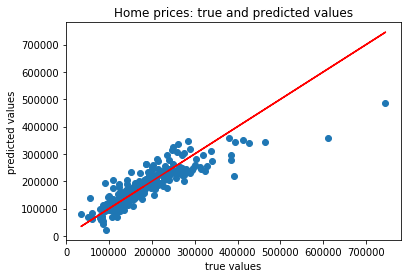

Mean absolute error of the prediction is: 25918.182225620916
Mean squared error of the prediction is: 1613861317.5099382
Root mean squared error of the prediction is: 40172.89281978506
Mean absolute percentage error of the prediction is: 14.73862010038557


In [40]:
# We add constant to the model as it's a best practice
# to do so every time!
X_test = sm.add_constant(X_test)

# We are making predictions here
y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Home prices: true and predicted values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

### Predict the house prices in the test set, and evaluate the performance of your model using the metrics we mentioned in this checkpoint.
### Is the performance of your model satisfactory? Why?

These numbers are all so big, but this model is dealing with relatively large values in the first place. The MAPE is only 14.73%, which doesn't seem bad. 

This model seems to do a decent job of prediction, except for a few large outliers. It makes me wonder if there is a variable we can add that will do a better job of accounting for those outliers, and the other larger values (> $400,000 or so, which is where the model starts coming up consistently short against the true values).

### Try to improve your model in terms of predictive performance by adding or removing some variables.

Let's take a look at the homes with higher sales prices. Maybe there are some features that are unique to higher-priced homes.

In [41]:
house_df['overallcond'].describe()

count    1460.000000
mean     5.575342   
std      1.112799   
min      1.000000   
25%      5.000000   
50%      5.000000   
75%      6.000000   
max      9.000000   
Name: overallcond, dtype: float64

In [42]:
house_df.loc[house_df['saleprice'] > 700000]

,mssubclass,mszoning,lotfrontage,lotarea,street,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremodadd,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating,heatingqc,centralair,firstflrsf,secondflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,fireplacequ,garagetype,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,miscval,mosold,yrsold,saletype,salecondition,saleprice,log_lotarea,has_porch,has_deck
691,60,RL,104.0,21535,Pave,IR1,Lvl,AllPub,Corner,Gtl,NoRidge,Norm,Norm,1Fam,2Story,10,6,1994,1995,Gable,WdShngl,HdBoard,HdBoard,BrkFace,1170.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,1455,Unf,0,989,2444,GasA,Ex,Y,2444,1872,0,4316,0,1,3,1,4,1,Ex,10,Typ,2,Ex,Attchd,1994,Fin,3,832,TA,TA,Y,382,50,0,0,0,0,0,1,2007,WD,Normal,755000,9.977435,1,1
1182,60,RL,160.0,15623,Pave,IR1,Lvl,AllPub,Corner,Gtl,NoRidge,Norm,Norm,1Fam,2Story,10,5,1996,1996,Hip,CompShg,Wd Sdng,ImStucc,None,0.0,Gd,TA,PConc,Ex,TA,Av,GLQ,2096,Unf,0,300,2396,GasA,Ex,Y,2411,2065,0,4476,1,0,3,1,4,1,Ex,10,Typ,2,TA,Attchd,1996,Fin,3,813,TA,TA,Y,171,78,0,0,0,555,0,7,2007,WD,Abnorml,745000,9.656499,1,1


I added two new features: the number of fireplaces, and an indicator as to whether or not the home has central air.

__Other features I tried and removed:__
1. '2story' - still insignificant
2. 'has_deck' - became insignificant with the removal of the other features I removed for this round
3. Dummies for 'heating', which added nothing significant
4. For fun, I tried a feature describing the interaction between a large lot and a large above-ground square footage--this turned out to be too highly correlated to those two variables to be useful. :(

In [50]:
# Append new features to the dataframe of interesting variables
house_interest_df['has_centralair'] = (house_df['centralair'].map({'Y': 1, 'N': 0}))
house_interest_df.head()

,saleprice,log_lotarea,neighborhood,bldgtype,housestyle,yearbuilt,fireplaces,heating,centralair,grlivarea,garagearea,has_deck,has_porch,Blueste,BrDale,BrkSide,ClearCr,CollgCr,Crawfor,Edwards,Gilbert,IDOTRR,MeadowV,Mitchel,NAmes,NPkVill,NWAmes,NoRidge,NridgHt,OldTown,SWISU,Sawyer,SawyerW,Somerst,StoneBr,Timber,Veenker,1.5Unf,1Story,2.5Fin,2.5Unf,2Story,SFoyer,SLvl,has_centralair
0,208500,9.041922,CollgCr,1Fam,2Story,2003,0,GasA,Y,1710,548,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
1,181500,9.169518,Veenker,1Fam,1Story,1976,1,GasA,Y,1262,460,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1
2,223500,9.328123,CollgCr,1Fam,2Story,2001,1,GasA,Y,1786,608,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
3,140000,9.164296,Crawfor,1Fam,2Story,1915,1,GasA,Y,1717,642,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
4,250000,9.565214,NoRidge,1Fam,2Story,2000,1,GasA,Y,2198,836,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1


In [44]:
# Try adding some features to explain higher-priced homes
hidf_features = ['log_lotarea','yearbuilt','grlivarea','garagearea','has_porch', #'has_deck',
                  'Edwards','fireplaces','has_centralair',
                  'Mitchel','NAmes','NWAmes','NoRidge','NridgHt','Sawyer',
                  'SawyerW','StoneBr','1.5Unf','1Story',
                  'SFoyer','SLvl']

In [45]:
# Y is the target variable
Y = house_interest_df['saleprice']

# X is the feature set.
X = house_interest_df[hidf_features]

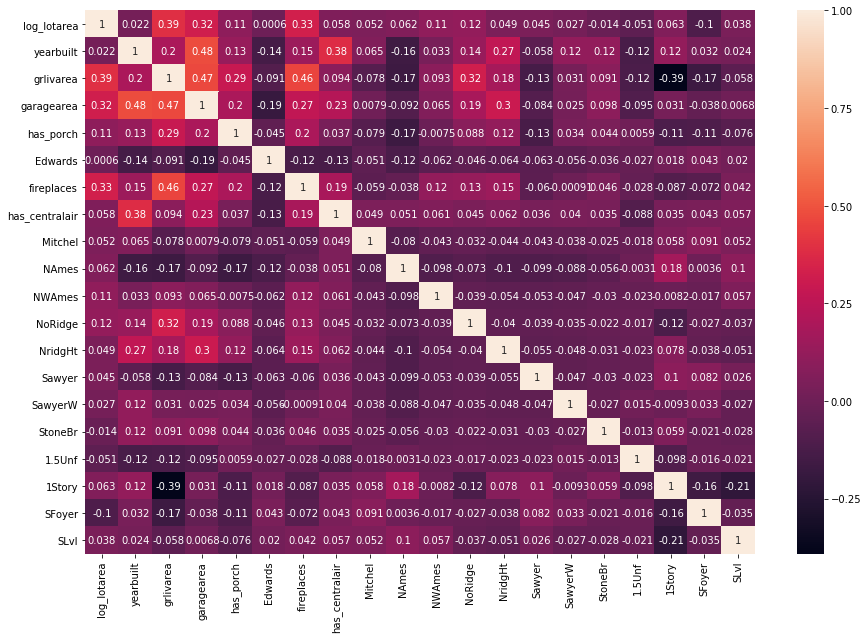

In [46]:
hidf_corr = house_interest_df[hidf_features].corr()
fig = plt.figure(figsize=(15,10))
sns.heatmap(hidf_corr,annot=True)

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

The number of observations in training set is 1168
The number of observations in test set is 292


In [48]:
# We add constant to the model as it's a best practice
# to do so ever ytime!
X_train = sm.add_constant(X_train)

# We fit an OLS model using statsmodels
results = sm.OLS(y_train, X_train).fit()

# We print the summary results
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.790
Model:                            OLS   Adj. R-squared:                  0.786
Method:                 Least Squares   F-statistic:                     215.8
Date:                Mon, 29 Jul 2019   Prob (F-statistic):               0.00
Time:                        12:31:02   Log-Likelihood:                -13914.
No. Observations:                1168   AIC:                         2.787e+04
Df Residuals:                    1147   BIC:                         2.798e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -1.349e+06   9.42e+04    -14.319      0.000   -1.53e+06   -1.16e+06
log_lotarea     1.917e+04   2485.800      7.711      0.000    1.43e+04     2.4e+04
yearbuilt        608.1985     46.191     13.167      0.000     517.570     698.827
grlivarea         67.4768      3.350     20.142      0.000      60.904      74.050
garagearea        37.8786      6.691      5.661      0.000      24.750      51.007
has_porch       5628.3781   2486.759      2.263      0.024     749.271    1.05e+04
Edwards        -2.477e+04   4607.046     -5.376      0.000   -3.38e+04   -1.57e+04
fireplaces      1.074e+04   1947.881      5.514      0.000    6918.130    1.46e+04
has_centralair  1.729e+04   4878.128      3.543      0.000    7714.255    2.69e+04
Mitchel        -2.555e+04   6342.583     -4.029      0.000    -3.8e+04   -1.31e+04
NAmes          -1.759e+04   3358.873     -5.237      0.000   -2.42e+04    -1.1e+04
NWAmes         -2.298e+04   5102.686     -4.503      0.000    -3.3e+04    -1.3e+04
NoRidge         5.914e+04   6965.551      8.490      0.000    4.55e+04    7.28e+04
NridgHt         6.075e+04   5142.529     11.813      0.000    5.07e+04    7.08e+04
Sawyer         -2.463e+04   5120.288     -4.811      0.000   -3.47e+04   -1.46e+04
SawyerW        -1.798e+04   5790.056     -3.105      0.002   -2.93e+04   -6620.043
StoneBr         8.682e+04   8928.549      9.724      0.000    6.93e+04    1.04e+05
1.5Unf           2.62e+04   1.09e+04      2.394      0.017    4726.532    4.77e+04
1Story          1.896e+04   2931.619      6.467      0.000    1.32e+04    2.47e+04
SFoyer           2.29e+04   7396.533      3.097      0.002    8391.699    3.74e+04
SLvl            1.189e+04   5866.530      2.027      0.043     383.666    2.34e+04
==============================================================================
Omnibus:                      304.390   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            17107.286
Skew:                          -0.238   Prob(JB):                         0.00
Kurtosis:                      21.743   Cond. No.                     2.26e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.26e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

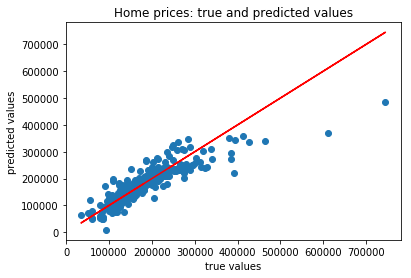

Mean absolute error of the prediction is: 25927.9848629077
Mean squared error of the prediction is: 1592897939.5663416
Root mean squared error of the prediction is: 39911.12551114465
Mean absolute percentage error of the prediction is: 14.606472360686492


In [49]:
# We add constant to the model as it's a best practice
# to do so every time!
X_test = sm.add_constant(X_test)

# We are making predictions here
y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Home prices: true and predicted values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

The new features helped a bit, but ultimately I think I am going to have to call the 28 homes with sale prices of over \\$400,000 outliers, and call this good. The other 1430-ish records are reasonably close to the model's predicted value.